# HomeTown Quotes Notebook

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.preprocessing import OneHotEncoder

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_excel("OctBidsSeenOnce.xlsx")

In [4]:
df.head(5)

,id,product,create_date,TheHour,TheDay,DayName,affiliate_id,affiliate_account_id,source,sub,bidamount,BidType,won_ping,consumer_ip_address,consumer_user_agent,city,state,zipcode,owns_home,months_in_residence,carrier_id,current_coverage_expiration,current_months_with_carrier,credit_type,license_valid,license_obtained_age,gender_type,marital_status_type,relationship_type,occupation,education_level,license_status,military_experience,bankruptcy,sr_22,mileage,use_type,commute_mileage,car_owned,coverage_type,comprehensive_deductible,collision_deductible,current_coverage,lead_certification_id,buyercid,NumVehicles,NumDrivers,expected_revenue
0,3632159922,AUTO,2023-10-10 00:00:03,0,10,Tuesday,2154,14068,14990100,Organic,6.28,LEG,0,75.167.22.219,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7...,Chandler,AZ,85249,1,12,313.0,2023-10-23,28.0,GOOD,1,16,MALE,MARRIED,SELF,OTHER,SOME_OR_NO_HIGH_SCHOOL,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,40,1,MINIMUM,50000,50000,1,D3E4C597-671D-7585-E27F-AA12EAF9433D,347.0,2,1,12.6
1,3632160078,AUTO,2023-10-10 00:00:28,0,10,Tuesday,1027,5232,Ig-8OzzwlDEYYckgQ7iq9HFV45W_qA,NaN,5.17,LEG,0,207.200.46.217,User Agent Not Available,Streator,IL,61364,0,0,313.0,2023-10-09,24.0,GOOD,1,16,MALE,MARRIED,SELF,OTHER,ASSOCIATES_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,VARIES,20,0,MINIMUM,10000,10000,1,1D145E0D-539B-043F-21C0-EB88A6E952BE,347.0,1,1,12.6
2,3632163844,AUTO,2023-10-10 00:11:32,0,10,Tuesday,2154,14068,14990100,Organic,5.71,LEG,0,147.219.76.110,Mozilla/5.0 (Linux; Android 10; K) AppleWebKit...,Madison,WI,53719,0,12,218.0,2023-10-23,28.0,GOOD,1,16,FEMALE,SINGLE,SELF,OTHER,SOME_OR_NO_HIGH_SCHOOL,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,40,1,MINIMUM,50000,50000,1,377B06F6-B870-9B2D-62B0-BEEBD5205A19,347.0,1,1,12.6
3,3632166774,AUTO,2023-10-10 00:19:34,0,10,Tuesday,1031,14315,94eca5b76e823a5d6e7628b51510de20,NaN,5.48,LEG,1,172.58.87.221,Mozilla/5.0 (iPhone; CPU iPhone OS 16_6_1 like...,Minneapolis,MN,55412,0,24,313.0,2023-10-17,12.0,FAIR,1,18,MALE,SINGLE,SELF,OTHER,BACHELORS_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,15,1,STANDARD,50000,50000,1,CEB82C8D-054B-8FC6-072B-7130430815F8,347.0,2,1,12.6
4,3632167194,AUTO,2023-10-10 00:20:52,0,10,Tuesday,1031,14315,94eca5b76e823a5d6e7628b51510de20,NaN,5.79,LEG,1,108.147.101.24,Mozilla/5.0 (iPhone; CPU iPhone OS 16_7 like M...,Danville,IL,61832,0,24,313.0,2023-10-17,12.0,FAIR,1,18,FEMALE,SINGLE,SELF,OTHER,BACHELORS_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,15,1,STANDARD,50000,50000,1,05C01EEC-06CE-5797-A978-5CB8CC21E271,347.0,1,1,12.6


In [5]:
df.shape

(50194, 48)

## Data Cleaning

In [6]:
def inspect_columns(df):
    """A helper function that does a better job than df.info() and df.describe()"""

    total_rows = len(df)
    result = pd.DataFrame({
        'total_rows': [total_rows] * df.shape[1],
        'rows_with_missing_values': df.isnull().sum(),
        'unique': df.nunique() == total_rows,
        'cardinality': df.nunique(),
        'with_null': df.isna().any(),
        'null_pct': round((df.isnull().sum() / total_rows) * 100, 2),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[np.random.randint(low=0, high=total_rows)],
        'last_row': df.iloc[-1],
        'dtype': df.dtypes,
    })
    return result

def categorize_columns(train, target_variable):
    numerical_data_types = ['int64', 'float64', 'datetime64[ns]']  # adjusted data types
    categorical_data_types = ['object']

    numerical_columns = [column for column in train.columns if train[column].dtype in numerical_data_types]
    print(f"Numerical variables ({len(numerical_columns)}): {numerical_columns}")

    categorical_columns = [column for column in train.columns if train[column].dtype in categorical_data_types]

    if target_variable in categorical_columns:
        categorical_columns.remove(target_variable)
    print(f"Categorical variables ({len(categorical_columns)}): {categorical_columns}")

    return numerical_columns, categorical_columns

Remove unnecessary columns

In [7]:
df = df.drop(columns=['id', 'create_date', 'consumer_ip_address', 
                      'consumer_user_agent', 'lead_certification_id', 
                      'product', 'sub', 'buyercid', 'carrier_id', 'city', 'zipcode', 'current_coverage_expiration',
                     'expected_revenue', 'source'])

product is always AUTO so we can remove it from df. Sub has many null, remove it.



For carrier, we can only remove the 145 rows with missing data.

In [8]:
inspect_columns(df)

,total_rows,rows_with_missing_values,unique,cardinality,with_null,null_pct,1st_row,random_row,last_row,dtype
TheHour,50194,0,False,24,False,0.00,0,13,23,int64
TheDay,50194,0,False,23,False,0.00,10,14,31,int64
DayName,50194,0,False,7,False,0.00,Tuesday,Saturday,Tuesday,object
affiliate_id,50194,0,False,16,False,0.00,2154,1031,2113,int64
affiliate_account_id,50194,0,False,22,False,0.00,14068,14315,5190,int64
bidamount,50194,0,False,1008,False,0.00,6.28,6.09,3.8,float64
BidType,50194,0,False,2,False,0.00,LEG,LEG,EXCLUSIVE,object
won_ping,50194,0,False,2,False,0.00,0,1,0,int64
state,50194,0,False,49,False,0.00,AZ,OH,GA,object
owns_home,50194,0,False,2,False,0.00,1,1,0,int64


In [9]:
def handle_missing_data(df, categorical_columns, numerical_columns, train=True):
    no_missing = df.copy()
    for column in categorical_columns:
        mode_val = no_missing[column].mode()[0]
        no_missing[column].fillna(mode_val, inplace=True)

    # Impute numerical columns with median
    for column in numerical_columns:
        median_val = no_missing[column].median()
        no_missing[column].fillna(median_val, inplace=True)
    return no_missing

def one_hot_encode_labels(data, label_columns):
    """
    One-hot encode a list of label columns in a DataFrame.

    Parameters:
    - data: DataFrame containing the label columns to be one-hot encoded.
    - label_columns: List of label column names to be one-hot encoded.

    Returns:
    - DataFrame with original data and one-hot encoded label columns.
    - Encoder object for potential inverse transformation.
    """
    encoder = OneHotEncoder(sparse=False, drop='first')
    encoded_labels = encoder.fit_transform(data[label_columns])

    # Create DataFrame for encoded labels
    data.reset_index(drop=True, inplace=True)

    encoded_df = pd.DataFrame(encoded_labels, columns=encoder.get_feature_names_out(label_columns))
    encoded_df.reset_index(drop=True, inplace=True)
    # Drop the original label columns and concatenate encoded DataFrame
    data = data.drop(label_columns, axis=1)
    data_encoded = pd.concat([data, encoded_df], axis=1)

    return data_encoded, encoder

def minmax_scale_data(data, numerical_columns, feature_range=(0, 1)):
    """
    Apply MinMax scaling to numerical columns in a DataFrame.

    Parameters:
    - data: DataFrame containing the numerical columns to be scaled.
    - numerical_columns: List of numerical column names to be scaled.
    - feature_range: Tuple (min, max) desired for scaling. Default is (0, 1).

    Returns:
    - DataFrame with scaled numerical columns.
    - Scaler object for potential inverse transformation.
    """
    scaler = MinMaxScaler(feature_range=feature_range)

    # Scaling numerical columns
    data[numerical_columns] = scaler.fit_transform(data[numerical_columns])

    return data, scaler

def SelectBest(X, y, alpha=0.01, K='all'):
    # fitting the kbest function
    bestFeatures = SelectKBest(score_func=f_regression, k=K)
    fit = bestFeatures.fit(X,y)
    new_X = bestFeatures.transform(X)
    # create dataframe for the results
    dfscores = pd.DataFrame(fit.scores_)
    dfpvalue = pd.DataFrame(fit.pvalues_)
    dfsignif = pd.DataFrame(fit.pvalues_ < alpha)
    dfcolumns = pd.DataFrame(X.columns)
    # concat dataframes for better visualization
    featureScores = pd.concat([dfcolumns,dfscores,dfpvalue,dfsignif],axis=1)
    # naming the dataframe columns and sorting
    featureScores.columns = ['Feature','ANOVA F-stats','p_value','p_value < alpha']
    featureScores.sort_values('ANOVA F-stats', inplace=True, ascending=False)
    featureScores = featureScores.loc[featureScores['p_value < alpha'] == True]
    return featureScores, new_X

def compute_mutual_information(X, y, threshold, seed=49):
    col_names = pd.DataFrame(X.columns)
    # MI computing
    mi = pd.DataFrame(mutual_info_regression(X,y,random_state=seed))
    # dataframe creation
    mutualInfo = pd.concat([col_names,mi],axis=1)
    # setting cols names
    mutualInfo.columns = ["Feature",'Importance']
    # ordering results
    mutualInfo.sort_values('Importance', inplace=True, ascending=False)
    mutualInfo = mutualInfo.loc[mutualInfo['Importance'] >= threshold]
    return mutualInfo

In [10]:
numerical_columns, categorical_columns = categorize_columns(df, 'won_ping')

Numerical variables (21): ['TheHour', 'TheDay', 'affiliate_id', 'affiliate_account_id', 'bidamount', 'won_ping', 'owns_home', 'months_in_residence', 'current_months_with_carrier', 'license_valid', 'license_obtained_age', 'bankruptcy', 'sr_22', 'mileage', 'commute_mileage', 'car_owned', 'comprehensive_deductible', 'collision_deductible', 'current_coverage', 'NumVehicles', 'NumDrivers']
Categorical variables (13): ['DayName', 'BidType', 'state', 'credit_type', 'gender_type', 'marital_status_type', 'relationship_type', 'occupation', 'education_level', 'license_status', 'military_experience', 'use_type', 'coverage_type']


In [11]:
no_missing = handle_missing_data(df, categorical_columns, numerical_columns)

In [12]:
no_missing.columns

Index(['TheHour', 'TheDay', 'DayName', 'affiliate_id', 'affiliate_account_id',
       'bidamount', 'BidType', 'won_ping', 'state', 'owns_home',
       'months_in_residence', 'current_months_with_carrier', 'credit_type',
       'license_valid', 'license_obtained_age', 'gender_type',
       'marital_status_type', 'relationship_type', 'occupation',
       'education_level', 'license_status', 'military_experience',
       'bankruptcy', 'sr_22', 'mileage', 'use_type', 'commute_mileage',
       'car_owned', 'coverage_type', 'comprehensive_deductible',
       'collision_deductible', 'current_coverage', 'NumVehicles',
       'NumDrivers'],
      dtype='object')

In [13]:
no_missing.head(2)

,TheHour,TheDay,DayName,affiliate_id,affiliate_account_id,bidamount,BidType,won_ping,state,owns_home,months_in_residence,current_months_with_carrier,credit_type,license_valid,license_obtained_age,gender_type,marital_status_type,relationship_type,occupation,education_level,license_status,military_experience,bankruptcy,sr_22,mileage,use_type,commute_mileage,car_owned,coverage_type,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers
0,0,10,Tuesday,2154,14068,6.28,LEG,0,AZ,1,12,28.0,GOOD,1,16,MALE,MARRIED,SELF,OTHER,SOME_OR_NO_HIGH_SCHOOL,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,COMMUTE_WORK,40,1,MINIMUM,50000,50000,1,2,1
1,0,10,Tuesday,1027,5232,5.17,LEG,0,IL,0,0,24.0,GOOD,1,16,MALE,MARRIED,SELF,OTHER,ASSOCIATES_DEGREE,ACTIVE,NO_MILITARY_EXPERIENCE,0,0,12500,VARIES,20,0,MINIMUM,10000,10000,1,1,1


In [14]:
label_columns = ['BidType', 'state', 'credit_type', 'gender_type', 'marital_status_type', 'relationship_type', 'occupation', 'education_level', 'license_status', 'military_experience', 'use_type', 'coverage_type']
hot_encoded, encoder = one_hot_encode_labels(no_missing, label_columns)

/Users/valentingarnier/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [15]:
hot_encoded.head(2)

,TheHour,TheDay,DayName,affiliate_id,affiliate_account_id,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,BidType_LEG,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR
0,0,10,Tuesday,2154,14068,6.28,0,1,12,28.0,1,16,0,0,12500,40,1,50000,50000,1,2,1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,10,Tuesday,1027,5232,5.17,0,0,0,24.0,1,16,0,0,12500,20,0,10000,10000,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [16]:
numerical_columns = [x for x in numerical_columns if (x != 'bidamount') and (x != 'TheDay') and (x != 'TheHour')]

In [17]:
scaled, scaler = minmax_scale_data(hot_encoded, numerical_columns, feature_range=(0, 1))

In [18]:
day_numbers = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday' :4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

scaled['DayName'] = scaled['DayName'].apply(lambda x: day_numbers[x])
scaled.head()

,TheHour,TheDay,DayName,affiliate_id,affiliate_account_id,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,BidType_LEG,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR
0,0,10,2,0.912551,0.973449,6.28,0.0,1.0,0.05,0.183007,0.0,0.00,0.0,0.0,0.166667,0.222857,1.0,0.444444,0.444444,1.0,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,10,2,0.000000,0.360901,5.17,0.0,0.0,0.00,0.156863,0.0,0.00,0.0,0.0,0.166667,0.108571,0.0,0.000000,0.000000,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0,10,2,0.912551,0.973449,5.71,0.0,0.0,0.05,0.183007,0.0,0.00,0.0,0.0,0.166667,0.222857,1.0,0.444444,0.444444,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,10,2,0.003239,0.990572,5.48,1.0,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.080000,1.0,0.444444,0.444444,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,10,2,0.003239,0.990572,5.79,1.0,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.0

In [19]:
scaled = scaled.drop(columns=['affiliate_id', 'affiliate_account_id'])

In [20]:
scaled.head()

,TheHour,TheDay,DayName,bidamount,won_ping,owns_home,months_in_residence,current_months_with_carrier,license_valid,license_obtained_age,bankruptcy,sr_22,mileage,commute_mileage,car_owned,comprehensive_deductible,collision_deductible,current_coverage,NumVehicles,NumDrivers,BidType_LEG,state_AL,state_AR,state_AZ,state_CA,state_CO,state_CT,state_DE,state_FL,state_GA,state_HI,state_IA,state_ID,state_IL,state_IN,state_KS,state_KY,state_LA,state_MA,state_MD,state_ME,state_MI,state_MN,state_MO,state_MS,state_MT,state_NC,state_ND,state_NE,state_NH,state_NJ,state_NM,state_NV,state_NY,state_OH,state_OK,state_OR,state_PA,state_SC,state_SD,state_TN,state_TX,state_UT,state_VA,state_VT,state_WA,state_WI,state_WV,state_WY,credit_type_FAIR,credit_type_GOOD,credit_type_POOR,gender_type_MALE,gender_type_NONBINARY,marital_status_type_MARRIED,marital_status_type_SEPARATED,marital_status_type_SINGLE,marital_status_type_WIDOWED,relationship_type_SELF,relationship_type_SPOUSE,occupation_CLERGY,occupation_CLERICAL,occupation_CONSTRUCTION_TRADE_LABORER,occupation_DISABLED,occupation_DOCTOR_DENTIST,occupation_EDUCATION_TRAINING,occupation_ENGINEER_SCIENTIST,occupation_HOMEMAKER,occupation_LAWYER_JUDGE,occupation_MILITARY_OTHER,occupation_OTHER,occupation_PRODUCTION_MANUFACTURING,occupation_RETAIL_SALES,occupation_RETIRED,occupation_SALES_OUTSIDE,occupation_SELF_EMPLOYED_BUSINESS_OWNER,occupation_SKILLED_WORKER,occupation_STUDENT_NOT_LIVING_W_PARENTS,occupation_UNEMPLOYED,education_level_BACHELORS_DEGREE,education_level_DOCTORATE_DEGREE,education_level_HIGH_SCHOOL_DIPLOMA,education_level_MASTERS_DEGREE,education_level_OTHER,education_level_SOME_COLLEGE,education_level_SOME_OR_NO_HIGH_SCHOOL,military_experience_OTHER,use_type_COMMUTE_SCHOOL,use_type_COMMUTE_WORK,use_type_PLEASURE,use_type_VARIES,coverage_type_MINIMUM,coverage_type_STANDARD,coverage_type_SUPERIOR
0,0,10,2,6.28,0.0,1.0,0.05,0.183007,0.0,0.00,0.0,0.0,0.166667,0.222857,1.0,0.444444,0.444444,1.0,0.333333,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,10,2,5.17,0.0,0.0,0.00,0.156863,0.0,0.00,0.0,0.0,0.166667,0.108571,0.0,0.000000,0.000000,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,0,10,2,5.71,0.0,0.0,0.05,0.183007,0.0,0.00,0.0,0.0,0.166667,0.222857,1.0,0.444444,0.444444,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0,10,2,5.48,1.0,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.080000,1.0,0.444444,0.444444,1.0,0.333333,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,0,10,2,5.79,1.0,0.0,0.10,0.078431,0.0,0.05,0.0,0.0,0.166667,0.080000,1.0,0.444444,0.444444,1.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0

<Axes: xlabel='DayName', ylabel='bidamount'>

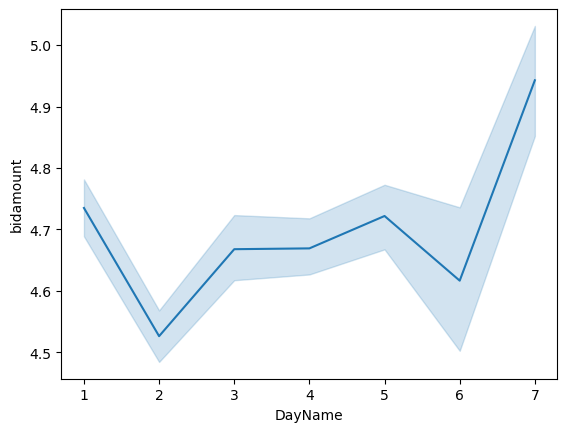

In [27]:
sns.lineplot(x="DayName", y="bidamount", data=scaled[scaled['won_ping'] == 1])

## Logistic Regression

In [32]:
X.bidamount.min(), X.bidamount.mean(), X.bidamount.max()

(0.09, 5.15357373391242, 12.99)

In [33]:
t = np.linspace(start=X.bidamount.min(), stop=X.bidamount.max(), num=10)
t

array([ 0.09      ,  1.52333333,  2.95666667,  4.39      ,  5.82333333,
        7.25666667,  8.69      , 10.12333333, 11.55666667, 12.99      ])

In [29]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# Split the dataset into features (X) and target variable (y)
X = scaled.drop(columns=['won_ping'])
y = scaled['won_ping']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = LogisticRegression()

# Train the model on the training set
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Print the results
print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{classification_rep}')


Accuracy: 0.8822591891622672
Confusion Matrix:
[[5029  446]
 [ 736 3828]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.92      0.89      5475
         1.0       0.90      0.84      0.87      4564

    accuracy                           0.88     10039
   macro avg       0.88      0.88      0.88     10039
weighted avg       0.88      0.88      0.88     10039



/Users/valentingarnier/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
